In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.stats import multivariate_normal
import pandas as pd


import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Dropout, BatchNormalization, LeakyReLU, Lambda
from keras.losses import Loss, binary_crossentropy, mean_squared_error
from keras.optimizers import Optimizer, Adam
from keras.metrics import Mean
from sklearn.model_selection import KFold
from keras.utils import to_categorical, plot_model, load_img, img_to_array
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import load_model


# Variational Autoencoder: Layer Classes

## Encoder

In [2]:
class Encoder(Layer):
    def __init__(self, layer_sizes: list[int] = [64, 128, 256, 512], 
                        input_size: tuple = (2,),
                        activation: str = 'relu', 
                        initializer: str = "he_uniform",
                        dropout_rate: float = 0.1, 
                        name = "Encoder") -> None:
        """
        Encoder Layer.

        Parameters:
        layer_sizes (List[int]): A list containing the number of units to be used in each Dense layer.
        activation (str): The activation function to be used in the Dense layers.
        initializer (str): The initializer to be used in the Dense layers.
        """

        super(Encoder, self).__init__(name = name)
        self.layer_size = layer_sizes
        self.input_size = input_size
        self.activation = activation
        self.initializer = initializer
        self.dropout_rate = dropout_rate

        # Flatten Layer
        #self.flatten = Flatten(name='Flatten')

        # Hidden Layers
        self.layers = []
        count = 0
        for size in layer_sizes:
            self.layers.append(Dense(units=size,
                                     kernel_initializer=self.initializer,
                                     activation=self.activation,
                                     name='DenseEncoder_{}'.format(count)))
            self.layers.append(BatchNormalization(name='BatchNormEncoder_{}'.format(count)))
            self.layers.append(Dropout(rate=self.dropout_rate, name='DropoutEncoder_{}'.format(count)))
            count += 1

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Performs the forward pass of the encoder layer.

        Parameters:
        x (tf.Tensor): The input tensor to be encoded.

        Returns:
        tf.Tensor: The encoded tensor.
        """

        #x = self.flatten(x)
        for layer in self.layers:
            x = layer(x)
        return x

## Latent

In [3]:
class Latent(Layer):
    def __init__(self, 
                 encoder: Encoder,  
                 dense_units: int = 128,  
                 dense_activation: str = 'relu',
                 mean_var_units: int = 4,  
                 mean_var_activation: str = None, 
                 initializer: str = 'he_uniform',
                 name: str = 'Latent'  
                ) -> None:

        """
        Latent Layer.
        
        Parameters:
        encoder (Encoder): An instance of the Encoder class.
        layer_sizes (int): The number of units (neurons) to be used in the Dense layer.
        activation (str): The activation function to be used in the Dense layers.
        initializer (str): The initializer to be used in the Dense layers.
        """

                       
        super(Latent, self).__init__(name = name)
        self.encoder = encoder  
        self.dense_units = dense_units
        self.dense_activation = dense_activation  
        self.mean_var_units = mean_var_units  
        self.mean_var_activation = mean_var_activation
        self.initializer = initializer  
        
        # Invert list of encoder layers to pass as the decoder layers
        # Decoder class will have access to decoder_layers
        self.decoder_layer_sizes = encoder.layer_size[::-1]

        self.dense_layer = Dense( units = dense_units, 
                        kernel_initializer = self.initializer, 
                        activation = self.dense_activation,
                        name = 'DenseLatent' )
        self.batch_norm = BatchNormalization(name='BatchNormLatent')

        # Dense layer for mean
        self.mean_layer = Dense(units=self.mean_var_units, 
                                activation = self.mean_var_activation,
                                kernel_initializer=self.initializer,
                                name='Mean')
        
        # Dense layer for log-variance
        self.log_var_layer = Dense(units=self.mean_var_units, 
                                  activation = self.mean_var_activation,
                                  kernel_initializer=self.initializer,
                                  name='LogVar')

    def call(self, x: tf.Tensor) -> tf.Tensor:

        """
        Forward pass of the Latent layer.

        Args:
        x (tf.Tensor): The input tensor.

        Returns:
        x (tf.Tensor): A list containing the mean and log-variance tensors.
        """
        x = self.dense_layer(x)
        x = self.batch_norm(x)
        # Compute the mean and variance
        mean = self.mean_layer(x)
        log_var = self.log_var_layer(x)
        return  [mean, log_var]

## Sampling

In [4]:
class Sampling(Layer):
    def __init__(self, latent: Latent, name: str = 'Sampling'):
        """
        Initialize the Sampling layer.

        Args:
            latent (Latent): Latent layer instance, used to obtain mean and log variance values.
        """
        super(Sampling, self).__init__(name = name)

        self.latent = latent

        # Create a Lambda layer that applies the sampling function
        self.z_layer = Lambda(self.sampling, name="ZLayer")

    def sampling(self, args):
        """
        Sampling function to generate z using the reparameterization trick.

        Args:
            args (list): List containing z_mean and z_log_var tensors.

        Returns:
            z (tensor): Sampled latent vector.
        """
        z_mean, z_log_var = args
        # Sample epsilon from a standard normal distribution with the same shape as mean
        epsilon = tf.random.normal(
            shape=tf.shape(z_mean), mean=0.0, stddev=1.0)
        # Compute z using the reparameterization trick
        z = z_mean + tf.math.exp(z_log_var / 2) * epsilon
        return z

    def call(self, inputs):
        """
        Forward pass of the Sampling layer.

        Args:
            inputs (list): List containing z_mean and z_log_var tensors.

        Returns:
            z (tensor): Sampled latent vector.
        """
        z_mean, z_log_var = inputs
        
        # Apply the Lambda layer with the sampling function to obtain z
        z = self.z_layer([z_mean, z_log_var])

        return z


## Decoder

In [5]:
class Decoder(Layer):
    def __init__(self, sampling: Sampling, 
                 activation: str = 'relu', 
                 output_activation: str = 'linear',  
                 initializer: str = "he_uniform", 
                 name: str = "Decoder" ) -> None:
        """Decoder Layer.

        Parameters:
        - latent: Latent object used to access the decoder layer sizes.
        
        - activation: Activation function for the dense layers.

        - output_activation: Activation function for the output layers.

        - initializer: Weights initializer for the dense layers.

        - input_img_size: Is the size of each image in the dataset. 
           Used to calculate the number of units in the output layer. 
        """
        super(Decoder, self).__init__(name = name)
        
        self.sampling = sampling
        self.activation = activation
        self.output_activation = output_activation
        self.initializer = initializer
        self.vae_input_size = self.sampling.latent.encoder.input_size

        # Output size defined accordingly to the Encoder input layer size
        # the idea is generate a symmetric number of layers compared to the Encoder
        self.layer_sizes = sampling.latent.decoder_layer_sizes

        # Hidden Layer
        self.layers = []
        count = 0
        for size in self.layer_sizes:
            self.layers.append(Dense(units=size, 
                                     kernel_initializer=self.initializer, 
                                     activation=self.activation,
                                     name='DenseDecoder_{}'.format(count)))
            count += 1
        
        self.layers.append(Dense(units= np.prod(self.vae_input_size), 
                                 kernel_initializer=self.initializer, 
                                 activation=self.output_activation, 
                                 name='Output'))
    
    
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Perform the forward step of the decoder layer.

        Parameters:
        x (Tensor): The input tensor.
        
        Returns:
        Tensor: output tensor.
        
        """
        for layer in self.layers:
            x = layer(x)
        return x


# Variational Autoencoder: Model

In [6]:
class VAE(Model):
    def __init__(self, 
                 encoder: Encoder,
                 latent: Latent,
                 sampling: Sampling,
                 decoder: Decoder,
                 alpha: int = 1,
                 beta: int = 1 ):
        """
        Variational Autoencoder (VAE) class that combines Encoder, Latent, Sampling, and Decoder components.

        Parameters:
        encoder (Encoder): Encoder layer instance.
        latent (Latent): Latent layer instance.
        sampling (Sampling): Sampling layer instance.
        decoder (Decoder): Decoder layer instance.
        alpha (int): Weight for the reconstruction loss.
        beta (int): Weight for the KL-divergence loss.
        """
        super(VAE, self).__init__()

        # Assign the provided components
        self.encoder = encoder
        self.latent = latent
        self.sampling = sampling
        self.decoder = decoder
        self.vae_input_size = self.encoder.input_size

        # Set the alpha and beta weights for the losses
        self.beta = beta
        self.alpha = alpha
        
        # Initialize loss trackers
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean( name="reconstruction_loss" )
        self.kl_loss_tracker = Mean(name="kl_loss")

    def call(self, x):
        # Pass the input through the Encoder
        x = self.encoder(x)
        # Compute the mean and log-variance of the latent distribution
        z_mean, z_log_var = self.latent(x)
        # Sample a latent point from the distribution
        z = self.sampling([z_mean, z_log_var])
        x  = self.decoder(z)
        
        return x, z, z_mean, z_log_var 
    
    def build_model(self): 
        x = Input(self.vae_input_size, name = "Input")
        return Model( inputs = x, 
                      outputs = self.call(x) )
    
    # Define metrics property to return the loss trackers
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    # Train step function
    def train_step(self, data):
        return self._process_step(data, training = True)
    
    # Test step function
    def test_step(self, data):
        return self._process_step(data, training = False)
    
    # Shared function for both train and test steps
    def _process_step(self, data, training):
        # Unpack the data tuple
        x, y = data

        # Record operations for automatic differentiation
        with tf.GradientTape(persistent = True) as tape:
            # Forward pass through the VAE
            y_pred,_ , z_mean, z_log_var = self(x, training = training )
            # Compute the total loss
            total_loss  = self.compute_loss(y , y_pred, z_mean, z_log_var)

        # Compute and apply gradients if in training mode
        if training:
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update the loss trackers
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(self.reconstruction_loss)
        self.kl_loss_tracker.update_state(self.kl_loss)
        
        # Return the losses as a dictionary
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def compute_loss(self, x, y_pred, z_mean, z_log_var):
        """
        Compute the total loss as a combination of reconstruction and KL-divergence losses.

        Args:
        x: Input data.
        y_pred: Predictions returned by the model (output of `model(x)`).
        z_mean: Mean of the latent distribution.
        z_log_var: Log-variance of the latent distribution.

        Returns:
        The total loss as a `tf.Tensor`.
        """
        # Compute the reconstruction loss 
        self.reconstruction_loss = self.alpha * tf.reduce_mean(tf.square(x - y_pred))

        # Compute the KL-divergence loss
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        self.kl_loss = self.beta * tf.reduce_mean(kl_loss, axis=1)
        
        # Calculate the total loss as the sum of the reconstruction and KL-divergence losses
        total_loss = self.reconstruction_loss + self.kl_loss

        return total_loss


## Model Summary

In [7]:
input = Input((2,))
encoder = Encoder()
latent = Latent(encoder)
sampling = Sampling(latent)
decoder = Decoder(sampling)

vae = Model(inputs = input, outputs = decoder.call(sampling.call( latent.call(encoder.call(input)))))

vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 DenseEncoder_0 (Dense)         (None, 64)           192         ['input_1[0][0]']                
                                                                                                  
 BatchNormEncoder_0 (BatchNorma  (None, 64)          256         ['DenseEncoder_0[0][0]']         
 lization)                                                                                        
                                                                                                  
 DropoutEncoder_0 (Dropout)     (None, 64)           0           ['BatchNormEncoder_0[0][0]'] 

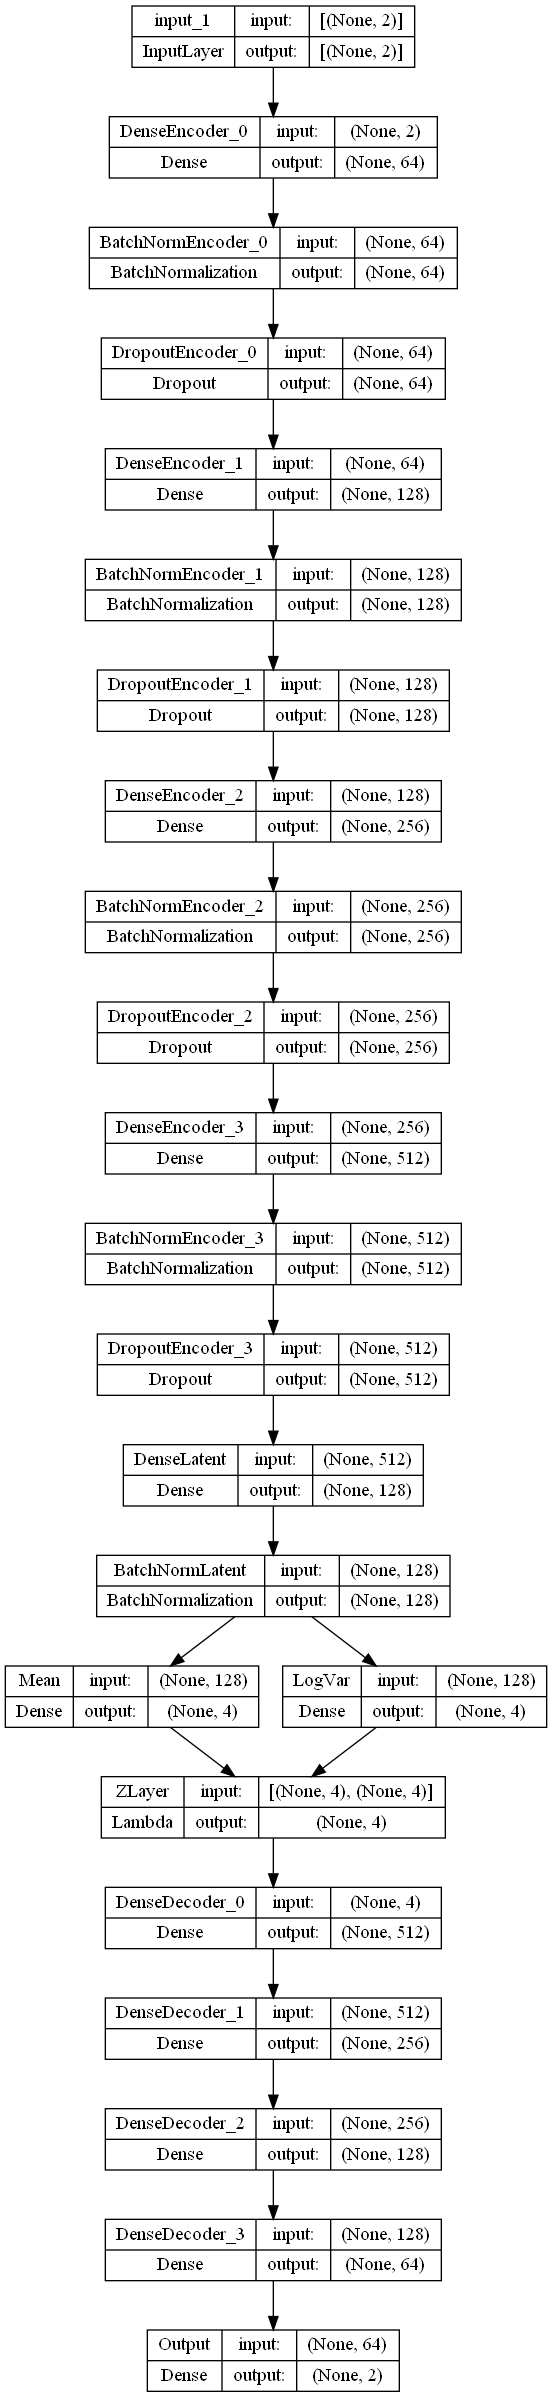

In [8]:
plot_model(vae, show_shapes=True, show_layer_names=True)

In [9]:
encoder = Encoder()
latent = Latent(encoder)
sampling = Sampling(latent)
decoder = Decoder(sampling)

vae =  VAE(encoder, latent, sampling, decoder).build_model()
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 2)]          0           []                               
                                                                                                  
 Encoder (Encoder)              (None, 512)          176960      ['Input[0][0]']                  
                                                                                                  
 Latent (Latent)                [(None, 4),          244168      ['Encoder[0][0]']                
                                 (None, 4)]                                                       
                                                                                                  
 Sampling (Sampling)            (None, 4)            244168      ['Latent[0][0]',           

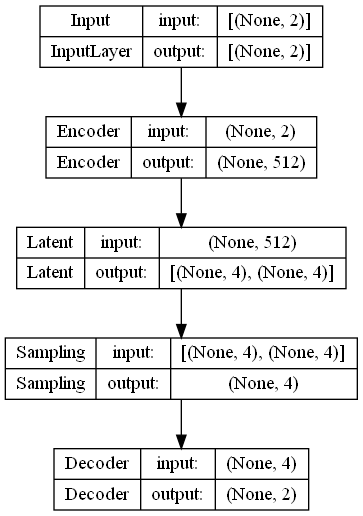

In [10]:
plot_model(vae, show_shapes=True, show_layer_names=True)

# Main

## Generate Data

In [11]:
def generate_gaussian_samples(n_samples = 3000):
    samples = []

    # Gaussian function
    gaussian_samples = []
    for i in range(n_samples):
        mu = np.random.uniform(-1, 1, size=2)
        sigma = np.random.uniform(0.8, 1.2)
        cov = np.eye(2) * sigma**2

        gaussian =np.random.multivariate_normal(mu, cov)
        gaussian_samples.append(gaussian)
    samples.append(gaussian_samples)

    # Sum of two Gaussian functions
    two_gaussian_samples = []
    for i in range(n_samples):
        mu1 = np.random.uniform(-1, 1, size=2)
        mu2 = np.random.uniform(-1, 1, size=2)
        sigma1 = np.random.uniform(0.8, 1.2)
        sigma2 = np.random.uniform(0.8, 1.2)
        cov1 = np.eye(2) * sigma1**2
        cov2 = np.eye(2) * sigma2**2

        two_gaussian = np.random.multivariate_normal(mu1, cov1) + np.random.multivariate_normal(mu2, cov2)
        two_gaussian_samples.append(two_gaussian)
    samples.append(two_gaussian_samples)

    # Gaussian function with a small perturbation
    perturbed_gaussian_samples = []
    for i in range(n_samples):
        mu = np.random.uniform(-1, 1, size=2)
        sigma = np.random.uniform(0.8, 1.2)
        conv = np.eye(2) * sigma**2
        
        gaussian = np.random.multivariate_normal(mu, conv)
        coeffs = np.random.uniform(0, 1, size=3)
        # p[0]*x**(N-1) + p[1]*x**(N-2) + ... + p[N-2]*x + p[N-1]
        perturbed_gaussian = np.polyval(coeffs, gaussian)
        perturbed_gaussian_samples.append(gaussian + perturbed_gaussian)
    samples.append(perturbed_gaussian_samples)

    return samples

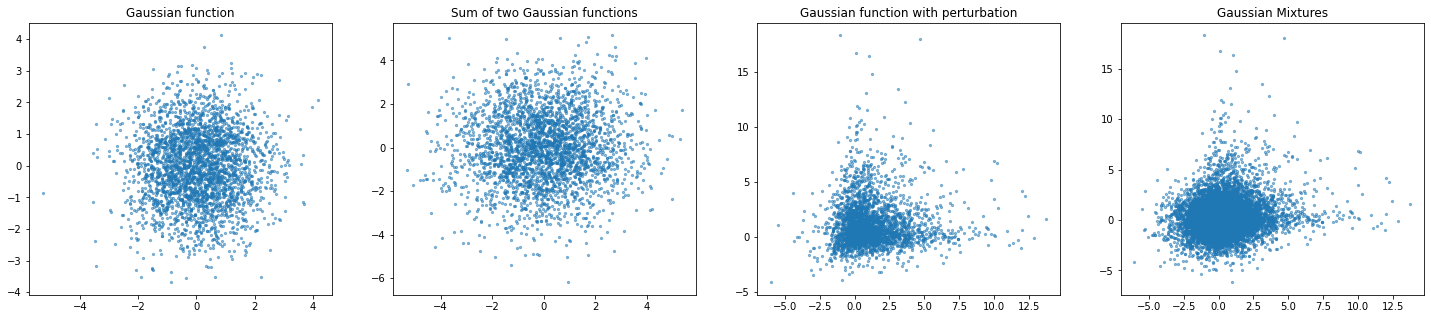

In [12]:
samples = generate_gaussian_samples()
# Plot samples
fig, axes = plt.subplots(1, 4, figsize=(25, 5))
# *np.array(samples[0]).T is equivalent to x = np.array(samples[0]).T[0], y = np.array(samples[0]).T[1] in scatter func
axes[0].scatter(*np.array(samples[0]).T, s=5, alpha=0.5)
axes[0].set_title('Gaussian function')
axes[1].scatter(*np.array(samples[1]).T, s=5, alpha=0.5)
axes[1].set_title('Sum of two Gaussian functions')
axes[2].scatter(*np.array(samples[2]).T, s=5, alpha=0.5)
axes[2].set_title('Gaussian function with perturbation')
all_samples = samples[0] + samples[1] + samples[2]
axes[3].scatter(*np.array(all_samples).T, s=5, alpha=0.5)
axes[3].set_title('Gaussian Mixtures')


plt.show()

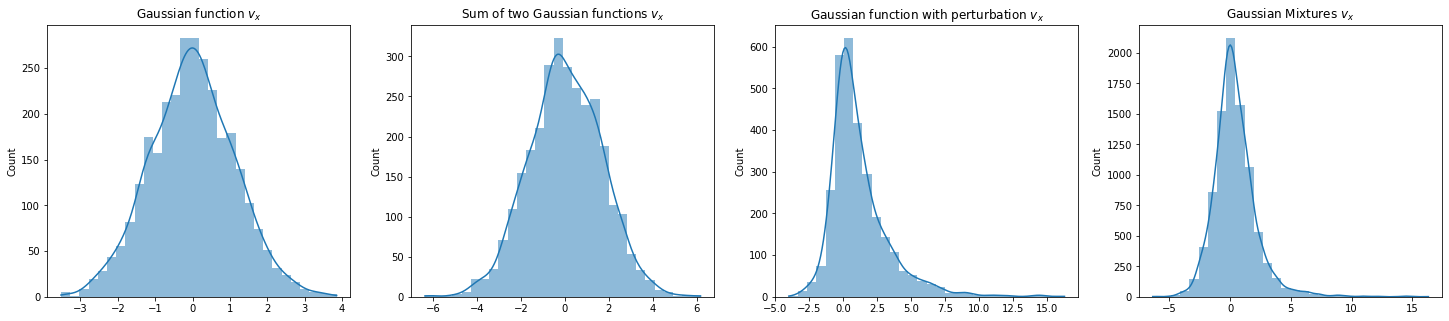

In [13]:
samples = generate_gaussian_samples()
fig, axes = plt.subplots(1, 4, figsize=(25,5))

# Gaussian function
sns.histplot(np.vstack(samples[0])[:, 0], bins=30, ax=axes[0], kde=True, linewidth=0)
axes[0].set_title('Gaussian function $v_x$')

# Sum of two Gaussian functions
sns.histplot(np.vstack(samples[1])[:, 0], bins=30, ax=axes[1], kde=True, linewidth=0)
axes[1].set_title('Sum of two Gaussian functions $v_x$')

# Gaussian function with perturbation
sns.histplot(np.vstack(samples[2])[:, 0], bins=30, ax=axes[2], kde=True, linewidth=0)
axes[2].set_title('Gaussian function with perturbation $v_x$')

all_samples = samples[0] + samples[1] + samples[2]
all_samples = np.vstack(all_samples)
sns.histplot(all_samples[:, 0], bins=30, ax=axes[3], kde=True, linewidth=0, alpha=0.5)
axes[3].set_title('Gaussian Mixtures $v_x$')


plt.show()

In [14]:
samples = generate_gaussian_samples(n_samples = 5000)
all_samples = samples[0] + samples[1] + samples[2]
data = np.vstack(all_samples)

size = data.shape[0]
x_train = data[:size,:]
x_test = data[:5000,:]


mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

## Train model

In [15]:
encoder = Encoder(layer_sizes = [64, 128, 256, 512, 1024])
latent = Latent(encoder)
sampling = Sampling(latent)
decoder = Decoder(sampling)

vae =  VAE(encoder, latent, sampling, decoder, alpha = 100, beta = 1)

vae.compile(optimizer = Adam(learning_rate = 0.0001))
history = vae.fit(x_train, x_train, epochs = 100, batch_size = 32, shuffle = True, validation_data=(x_test, x_test) )

Epoch 1/100
469/469 [==============================] - 8s 13ms/step - loss: 94.4071 - reconstruction_loss: 58.5991 - kl_loss: 3.3229 - val_loss: 20.4057 - val_reconstruction_loss: 17.9783 - val_kl_loss: 2.4344
Epoch 2/100
469/469 [==============================] - 6s 12ms/step - loss: 35.4787 - reconstruction_loss: 28.1268 - kl_loss: 4.5497 - val_loss: 11.3494 - val_reconstruction_loss: 8.4256 - val_kl_loss: 2.9076
Epoch 3/100
469/469 [==============================] - 6s 13ms/step - loss: 27.7121 - reconstruction_loss: 22.6371 - kl_loss: 4.6484 - val_loss: 12.0314 - val_reconstruction_loss: 9.1551 - val_kl_loss: 2.8576
Epoch 4/100
469/469 [==============================] - 6s 13ms/step - loss: 25.5511 - reconstruction_loss: 19.8168 - kl_loss: 4.2752 - val_loss: 8.5738 - val_reconstruction_loss: 5.8614 - val_kl_loss: 2.7081
Epoch 5/100
469/469 [==============================] - 6s 13ms/step - loss: 21.0230 - reconstruction_loss: 17.0058 - kl_loss: 4.0755 - val_loss: 6.5444 - val_recons

# Show results

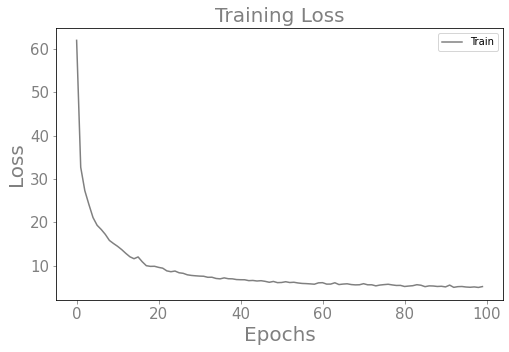

In [19]:
fig, axs = plt.subplots(figsize=(8,5))

axs.plot(history.history['loss'], color = 'gray')
axs.set_title('Training Loss', color = 'gray',fontsize =20)
axs.set_xlabel('Epochs', color = "gray", fontsize =20)
axs.set_ylabel('Loss', color = "gray", fontsize =20)
axs.tick_params(axis ='both', colors = 'gray', labelsize = 15)
axs.legend(['Train'])

plt.show()

469/469 [==============================] - 2s 4ms/step


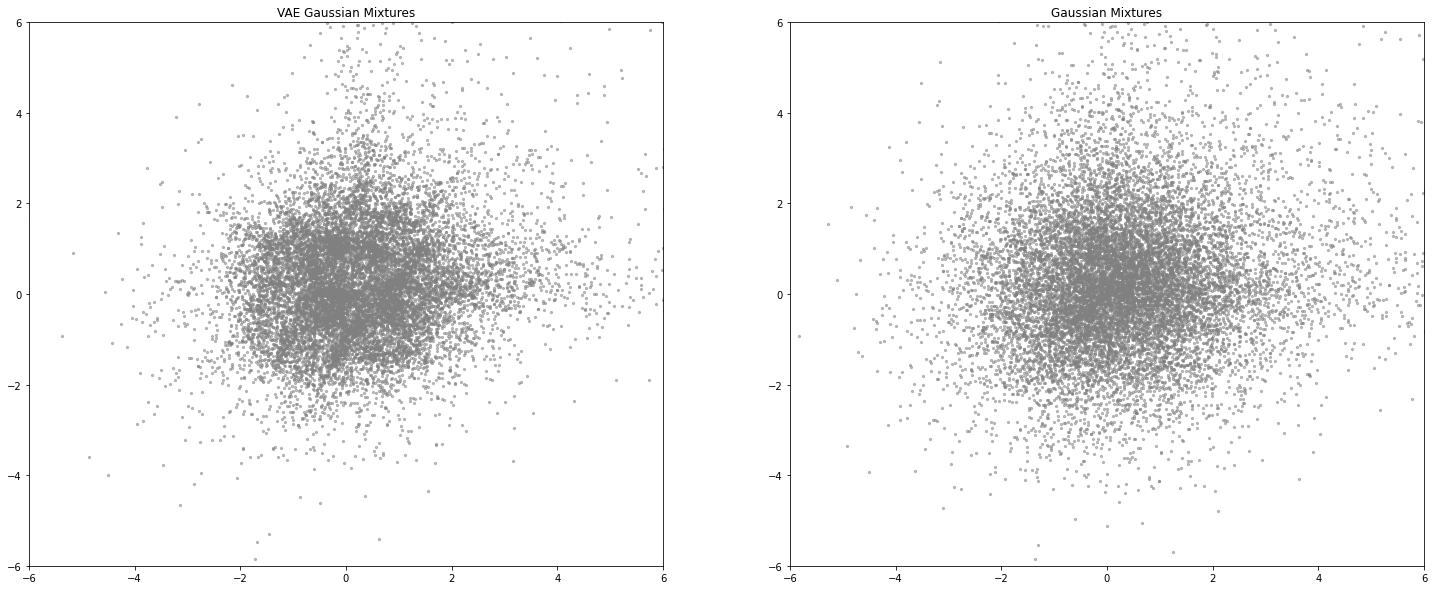

In [23]:
output = vae.predict(x_train)
vae_gaussian_mix = output[0]*std + mean

# Plot samples
fig, axes = plt.subplots(1 , 2, figsize=(25, 10))
# *np.array(samples[0]).T is equivalent to x = np.array(samples[0]).T[0], y = np.array(samples[0]).T[1] in scatter func
axes[0].scatter(*np.array(vae_gaussian_mix).T, s=5, c = 'grey', alpha=0.5)
axes[0].set_title('VAE Gaussian Mixtures')
axes[0].set_xlim(-6,6)
axes[0].set_ylim(-6,6)

gaussian_mix = samples[0] + samples[1] + samples[2]
axes[1].scatter(*np.array(gaussian_mix).T, c = 'grey', s=5, alpha=0.5)
axes[1].set_title('Gaussian Mixtures')
axes[1].set_xlim(-6,6)
axes[1].set_ylim(-6,6)

plt.show()

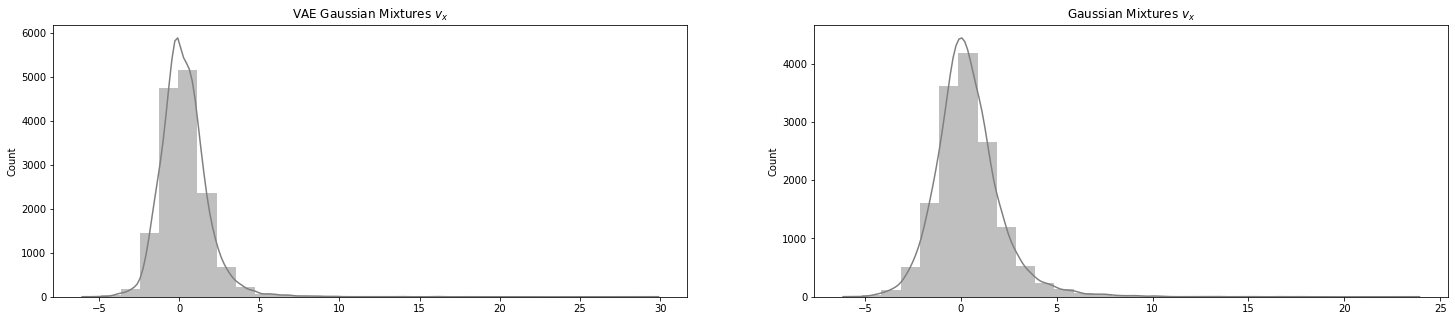

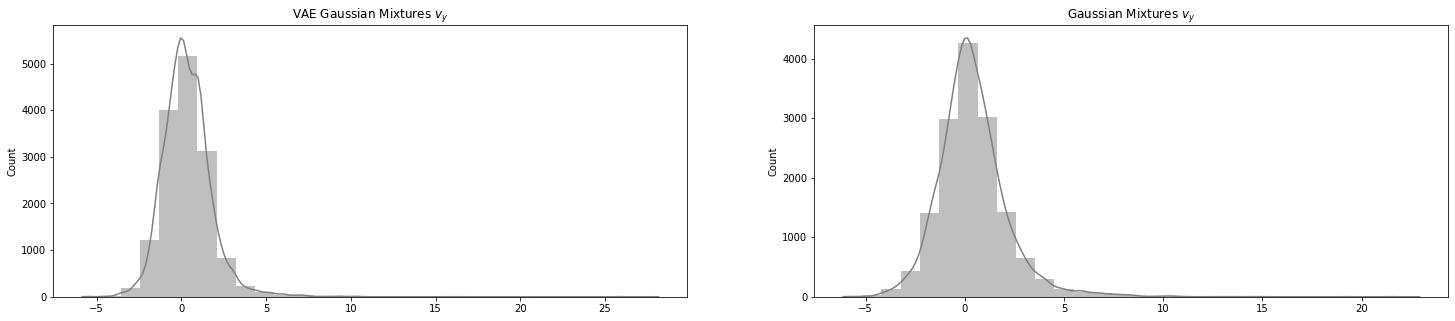

In [30]:
def plot_histograms(vae_data, original_data, titles, figsize=(25, 5)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    sns.histplot(vae_data, bins=30, ax=axes[0], kde=True, color = 'grey', linewidth=0)
    axes[0].set_title(titles[0])

    sns.histplot(original_data, bins=30, ax=axes[1], kde=True, color = 'grey', linewidth=0, alpha=0.5)
    axes[1].set_title(titles[1])

    plt.show()

gaussian_mix = np.vstack(samples[0] + samples[1] + samples[2])
# For v_x
plot_histograms(vae_gaussian_mix[:, 0], gaussian_mix[:, 0],
                ['VAE Gaussian Mixtures $v_x$', 'Gaussian Mixtures $v_x$'])

# For v_y
plot_histograms(vae_gaussian_mix[:, 1], gaussian_mix[:, 1],
                ['VAE Gaussian Mixtures $v_y$', 'Gaussian Mixtures $v_y$'])